# Win probability vs models

The purpose of this notebook is to compare the predicted win probability for models with measures of how much a team won by. This will be used in the paper.

In [182]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Predictions data

In [9]:
df = pd.read_csv('../data/Final Data/start_to_finish_with_preds_and_scores.csv')

In [10]:
df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,xgb_pred,knn_pred,knn_no_batting_pred,nn_pred,xgb_proba,knn_proba,knn_no_batting_proba,nn_proba,home_score,away_score
0,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505,4,1
1,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505,6,5
2,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505,5,1
3,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.377228,0.473333,0.506667,0.395637,3,5
4,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,0.0,0.0,1.0,0,0.377228,0.473333,0.506667,0.395637,3,5


## Score differential

We will model score differential by a probability distribution. The idea is to transform the score differential into a scale that makes sense. For example, is winning by 2 "twice as good" as winning by 1? Probably not. So we want to probabilistically rescale it so that score differentials are expressed in a historical context.

We'll do this by getting an answer to the following question: In what percentage of all games did the home team win by the given score differential or less? For example, in what percentage of games did the home team win by 5 or less runs?

While this is phrased in terms of home team wins, obviously the away team can win as well. So a negative score differential will indicate an away team win. Thus "what percentage of the time did the home team win by -3 or less" is equivalent to saying "what percentage of the time did the away team win by 3 or less."

The advantage of this approach is two-fold:
1. It scales the score differential between -1 and 1
2. It allows context, as discussed above.

### Raw score differential

In [12]:
df['score_diff'] = df['home_score'] - df['away_score']

<AxesSubplot:ylabel='Frequency'>

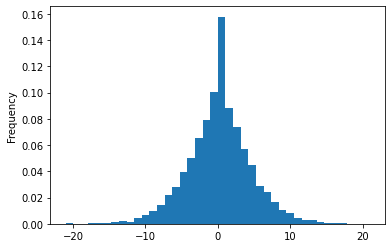

In [16]:
df['score_diff'].plot(kind='hist', density=True, bins=40)

### Scaled score differential

Split into home and away team wins.

In [125]:
home_win_df = df[df['home_win'] == 1]
away_win_df = df[df['home_win'] == 0]

In [126]:
assert home_win_df.shape[0] + away_win_df.shape[0] == df.shape[0]

<AxesSubplot:ylabel='Frequency'>

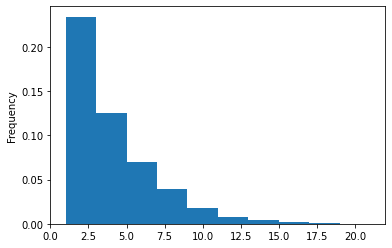

In [127]:
home_win_df['score_diff'].plot(kind='hist', density=True)

<AxesSubplot:ylabel='Frequency'>

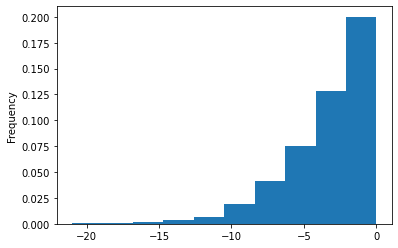

In [128]:
away_win_df['score_diff'].plot(kind='hist', density=True)

Create cumulative distributions by summing up from zero to $\pm$ largest score differential.

In [129]:
home_prob_by_diff = home_win_df['score_diff'].value_counts().sort_index() / home_win_df.shape[0]
away_prob_by_diff = away_win_df['score_diff'].value_counts().sort_index() / away_win_df.shape[0]
home_prob_by_diff

1     0.300709
2     0.168134
3     0.140525
4     0.109411
5     0.085135
6     0.054962
7     0.045730
8     0.032225
9     0.019745
10    0.015642
11    0.009146
12    0.005898
13    0.005129
14    0.003248
15    0.001197
16    0.001795
17    0.000513
18    0.000256
19    0.000171
20    0.000342
21    0.000085
Name: score_diff, dtype: float64

In [130]:
away_prob_by_diff

-21    0.000210
-20    0.000419
-19    0.000105
-18    0.000210
-17    0.000629
-16    0.001048
-15    0.002097
-14    0.003250
-13    0.005242
-12    0.003879
-11    0.010378
-10    0.015620
-9     0.023692
-8     0.034175
-7     0.051997
-6     0.064891
-5     0.092253
-4     0.117413
-3     0.152322
-2     0.185030
-1     0.234825
 0     0.000314
Name: score_diff, dtype: float64

In [143]:
home_win_cdf = np.cumsum(home_prob_by_diff)

# Since score differentials in away_prob_by_diff are negative, we need to sum it up backwards. 
# https://stackoverflow.com/questions/16541618/perform-a-reverse-cumulative-sum-on-a-numpy-array/16541726
# We also make it negative so that away team wins have negative dominance.
away_win_cdf = -np.cumsum(away_prob_by_diff[::-1])[::-1]

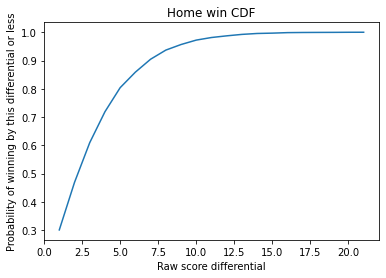

In [144]:
plt.plot(home_win_cdf.index, home_win_cdf)
plt.xlabel('Raw score differential')
plt.ylabel('Probability of winning by this differential or less')
plt.title('Home win CDF');

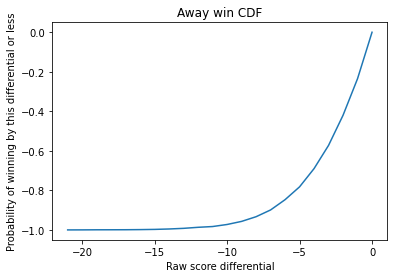

In [146]:
plt.plot(away_win_cdf.index, away_win_cdf)
plt.xlabel('Raw score differential')
plt.ylabel('Probability of winning by this differential or less')
plt.title('Away win CDF');

In [150]:
dominance_df = pd.concat([away_win_cdf, home_win_cdf])

In [153]:
dominance_df

-21   -1.000000
-20   -0.999790
-19   -0.999371
-18   -0.999266
-17   -0.999057
-16   -0.998428
-15   -0.997379
-14   -0.995283
-13   -0.992033
-12   -0.986791
-11   -0.982912
-10   -0.972534
-9    -0.956914
-8    -0.933222
-7    -0.899046
-6    -0.847049
-5    -0.782157
-4    -0.689905
-3    -0.572492
-2    -0.420170
-1    -0.235140
 0    -0.000314
 1     0.300709
 2     0.468843
 3     0.609368
 4     0.718779
 5     0.803915
 6     0.858877
 7     0.904607
 8     0.936832
 9     0.956577
 10    0.972220
 11    0.981366
 12    0.987264
 13    0.992393
 14    0.995641
 15    0.996837
 16    0.998632
 17    0.999145
 18    0.999402
 19    0.999573
 20    0.999915
 21    1.000000
Name: score_diff, dtype: float64

Looks like a sigmoid function!

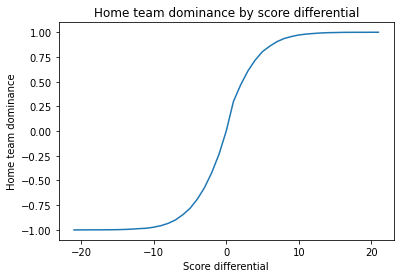

In [154]:
plt.plot(dominance_df.index, dominance_df.values)
plt.title('Home team dominance by score differential')
plt.xlabel('Score differential')
plt.ylabel('Home team dominance');

Now let's make a function which, given a score differential, returns the "dominance" score.

In [157]:
def dominance(score_diff):
    return dominance_df.loc[score_diff]

## Dominance vs predicted probability

In [160]:
df['dominance'] = df['score_diff'].map(dominance)

In [185]:
df['nn_proba_scaled'] = (df['nn_proba'] - 0.5) * 2
df['xgb_proba_scaled'] = (df['xgb_proba'] - 0.5) * 2
df['knn_proba_scaled'] = (df['knn_proba'] - 0.5) * 2

In [220]:
df['nn_proba_scaled_rounded'] = np.round(df['nn_proba_scaled'], 1)
df['xgb_proba_scaled_rounded'] = np.round(df['xgb_proba_scaled'], 1)
df['knn_proba_scaled_rounded'] = np.round(df['knn_proba_scaled'], 1)

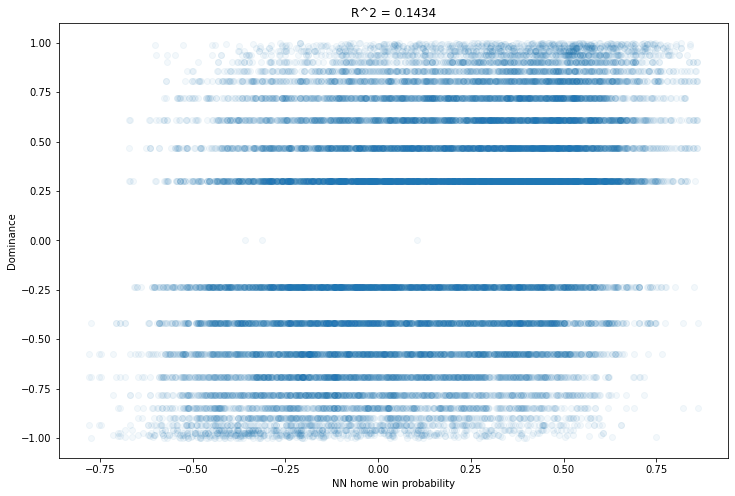

In [170]:
plt.figure(figsize=(12, 8))
plt.scatter((df['nn_proba'] - 0.5) * 2, df['dominance'], alpha=0.05)
plt.xlabel('NN home win probability')
plt.ylabel('Dominance');
plt.title(f'R^2 = {np.corrcoef(df["dominance"], df["nn_proba"])[0, 1]**2:.4f}');

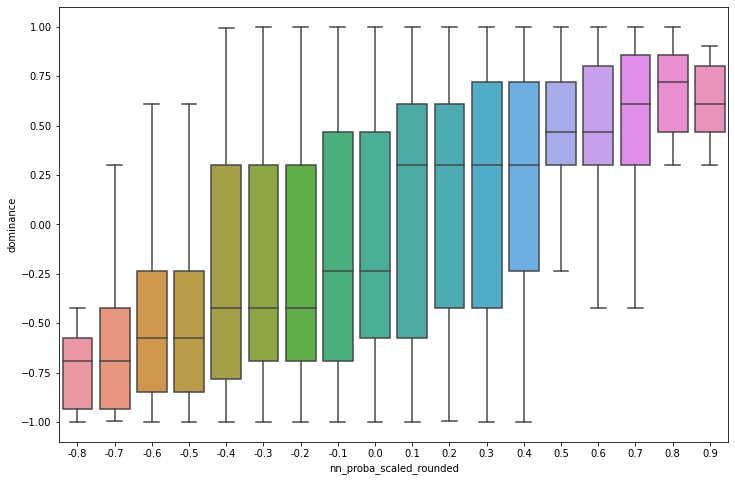

In [209]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='nn_proba_scaled_rounded', y='dominance', data=df, fliersize=0, orient='v');

<AxesSubplot:xlabel='nn_proba_scaled', ylabel='dominance'>

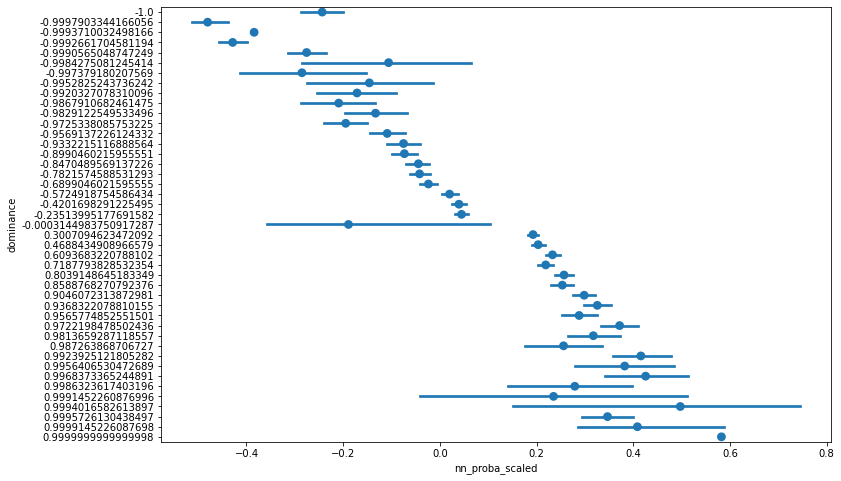

In [194]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled', y='dominance', data=df, orient='h', join=False)

<AxesSubplot:xlabel='nn_proba_scaled_rounded', ylabel='dominance'>

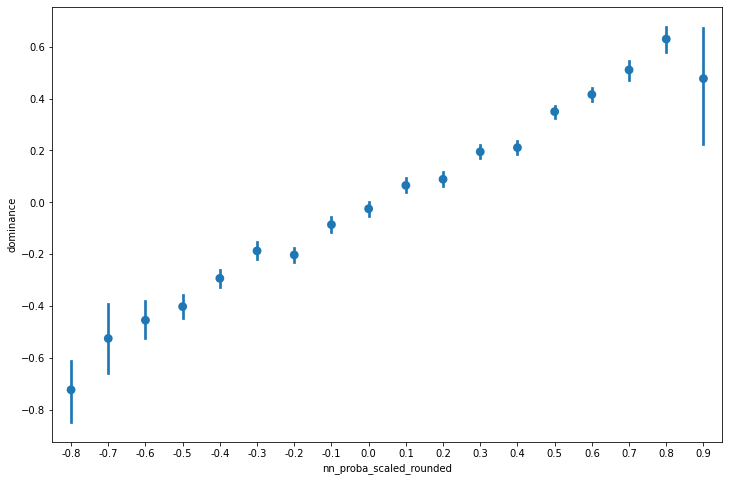

In [207]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled_rounded', y='dominance', data=df, orient='v', join=False)

<AxesSubplot:xlabel='nn_proba_scaled_rounded', ylabel='score_diff'>

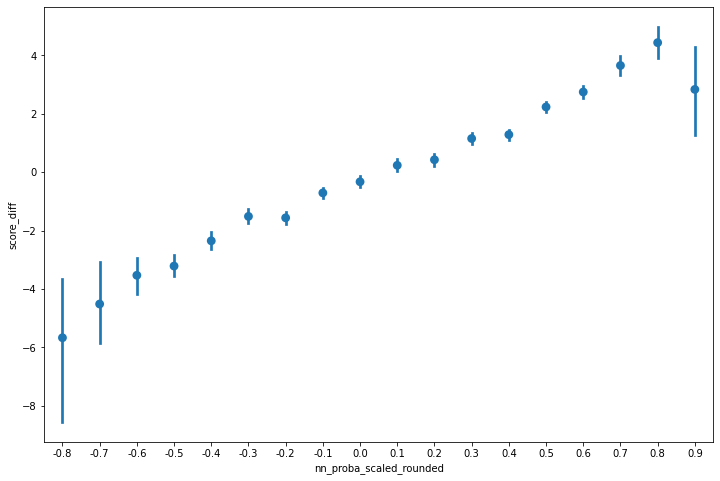

In [200]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled_rounded', y='score_diff', data=df, orient='v', join=False)

<AxesSubplot:xlabel='nn_proba_scaled', ylabel='score_diff'>

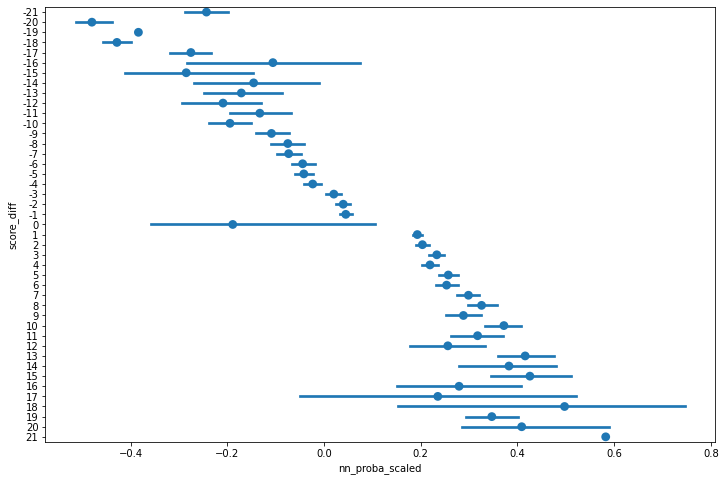

In [195]:
plt.figure(figsize=(12, 8))

sns.pointplot(x='nn_proba_scaled', y='score_diff', data=df, orient='h', join=False)

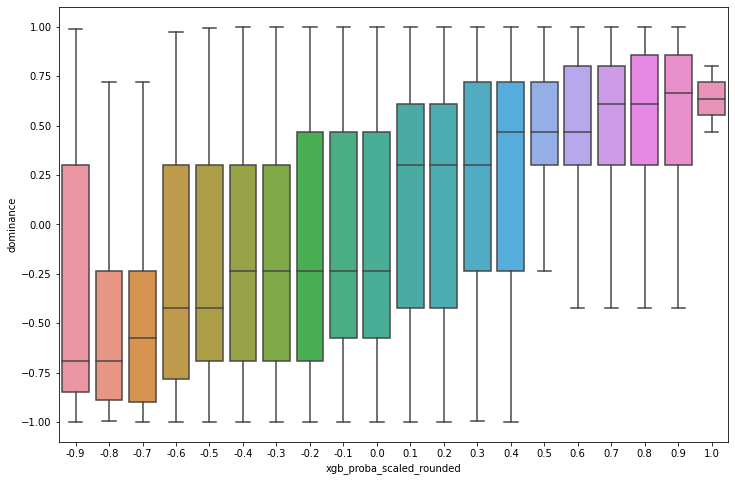

In [221]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='xgb_proba_scaled_rounded', y='dominance', data=df, fliersize=0, orient='v');

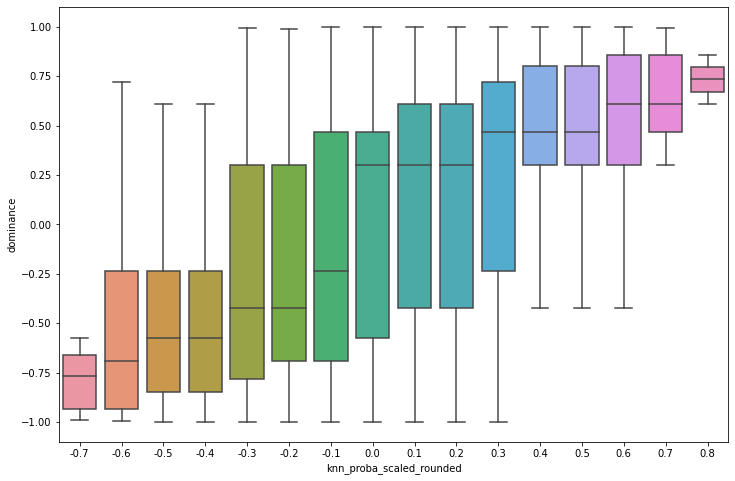

In [222]:
plt.figure(figsize=(12, 8))

sns.boxplot(x='knn_proba_scaled_rounded', y='dominance', data=df, fliersize=0, orient='v');

Text(0.5, 1.0, 'R^2 = 0.1363')

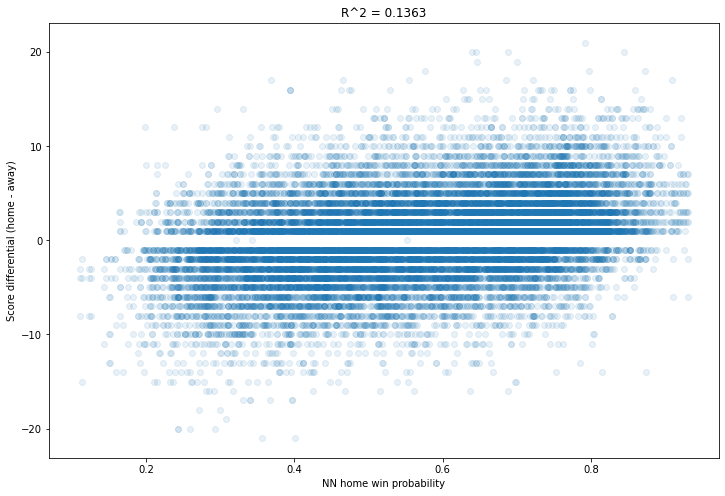

In [64]:
plt.figure(figsize=(12, 8))
plt.scatter(df['nn_proba'], df['score_diff'], alpha=0.1)
plt.xlabel('NN home win probability')
plt.ylabel('Score differential (home - away)');
plt.title(f'R^2 = {np.corrcoef(df["nn_proba"], df["score_diff"])[0, 1]**2:.4f}');

Text(0.5, 1.0, 'R^2 = 0.1171')

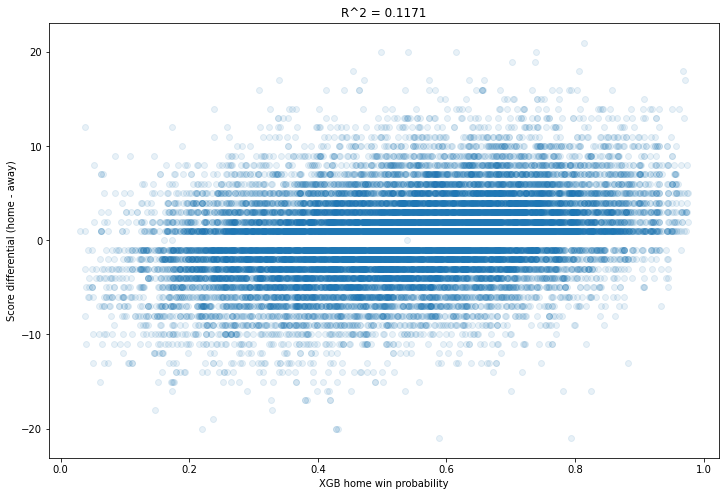

In [65]:
plt.figure(figsize=(12, 8))
plt.scatter(df['xgb_proba'], df['score_diff'], alpha=0.1)
plt.xlabel('XGB home win probability')
plt.ylabel('Score differential (home - away)');
plt.title(f'R^2 = {np.corrcoef(df["xgb_proba"], df["score_diff"])[0, 1]**2:.4f}');

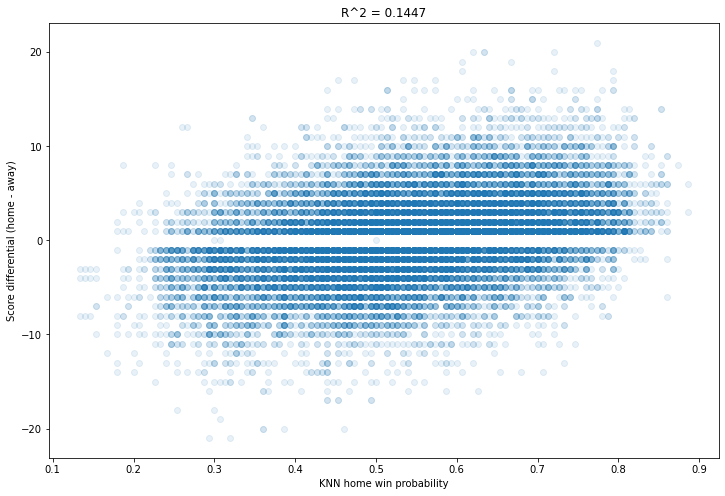

In [66]:
plt.figure(figsize=(12, 8))
plt.scatter(df['knn_proba'], df['score_diff'], alpha=0.1)
plt.xlabel('KNN home win probability')
plt.ylabel('Score differential (home - away)');
plt.title(f'R^2 = {np.corrcoef(df["knn_proba"], df["score_diff"])[0, 1]**2:.4f}');

## Statistics

Here I'll calculate some relevant statistics. These will be good for including in the abstract. In general, the statistics below focus more on the _probabilities_, rather than on simply making a correct prediction or not. We know our models don't make win/loss predictions at _quite_ state of the art, they're slightly below. But our probabilities are better, as the metrics below show.

### Brier score

[Discussed here](https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/), lower is better. The Brier scores below are better than in the papers we read.

In [210]:
from sklearn.metrics import brier_score_loss

In [214]:
print(f'NN Brier score = {brier_score_loss(df["home_win"], df["nn_proba"]):.4f}')
print(f'XGB Brier score = {brier_score_loss(df["home_win"], df["xgb_proba"]):.4f}')
print(f'KNN Brier score = {brier_score_loss(df["home_win"], df["knn_proba"]):.4f}')

NN Brier score = 0.2166
XGB Brier score = 0.2217
KNN Brier score = 0.2167


### Area under ROC curve
[Discussed here](https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/), higher is better. These are better than in the papers we read.

In [215]:
from sklearn.metrics import roc_auc_score

In [218]:
print(f"NN AUROC = {roc_auc_score(df['home_win'], df['nn_proba']):.4f}")
print(f"XGB AUROC = {roc_auc_score(df['home_win'], df['xgb_proba']):.4f}")
print(f"KNN AUROC = {roc_auc_score(df['home_win'], df['knn_proba']):.4f}")

NN AUROC = 0.7046
XGB AUROC = 0.6898
KNN AUROC = 0.7111


## Comparison to 538

Fivethirtyeight makes their [predictions available](https://github.com/fivethirtyeight/data/tree/master/mlb-elo), which include win probabilities. Let's compare our results to theirs.

In [228]:
fte_df = pd.read_csv('../data/538_mlb_elo.csv')

In [229]:
fte_df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2021-10-03,2021,0,NaN,ATL,NYM,1551.109895,1503.501067,0.601619,0.398381,...,NaN,NaN,NaN,NaN,0.575795,0.424205,NaN,NaN,NaN,NaN
1,2021-10-03,2021,0,NaN,STL,CHC,1502.349243,1468.771068,0.582111,0.417889,...,NaN,NaN,NaN,NaN,0.566486,0.433514,NaN,NaN,NaN,NaN
2,2021-10-03,2021,0,NaN,SEA,ANA,1506.798810,1481.622155,0.570302,0.429698,...,NaN,NaN,NaN,NaN,0.545822,0.454178,NaN,NaN,NaN,NaN
3,2021-10-03,2021,0,NaN,LAD,MIL,1595.777724,1547.693001,0.602275,0.397725,...,NaN,NaN,NaN,NaN,0.614708,0.385292,NaN,NaN,NaN,NaN
4,2021-10-03,2021,0,NaN,KCR,MIN,1469.856717,1482.131210,0.516868,0.483132,...,NaN,NaN,NaN,NaN,0.498403,0.501597,NaN,NaN,NaN,NaN


In [232]:
fte_df = fte_df[fte_df['season'] >= 2016]
fte_df = fte_df[fte_df['season'] <= 2019]

Based on eyeballing the data and [the website](https://projects.fivethirtyeight.com/2019-mlb-predictions/games/) _I think_ `team1` is the away team and `team2` is the home team.

In [233]:
fte_df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
3380,2019-10-30,2019,0,w,HOU,WSN,1599.542804,1584.363378,0.574617,0.425383,...,56.920649,61.723620,0.989236,27.776342,0.515172,0.484828,1587.973463,1583.382133,2.0,6.0
3381,2019-10-29,2019,0,w,HOU,WSN,1605.069000,1578.837182,0.595209,0.404791,...,62.975093,60.272516,28.723451,21.776276,0.594638,0.405362,1591.026009,1580.329587,2.0,7.0
3382,2019-10-27,2019,0,w,WSN,HOU,1584.005206,1599.900976,0.515546,0.484454,...,49.433198,66.891460,-29.811205,47.888341,0.373102,0.626898,1576.189971,1595.165625,1.0,7.0
3383,2019-10-26,2019,0,w,WSN,HOU,1589.985555,1593.920627,0.538425,0.461575,...,56.003581,51.251046,0.823752,-24.893480,0.586974,0.413026,1578.722119,1592.633477,1.0,8.0
3384,2019-10-25,2019,0,w,WSN,HOU,1593.827376,1590.078806,0.553044,0.446956,...,54.036365,57.096801,-9.053908,2.440389,0.526852,0.473148,1583.715416,1587.640180,1.0,4.0


In [272]:
fte_df['score_diff'] = fte_df['score1'] - fte_df['score2']

In [273]:
fte_df['home_win_prob_rounded'] = fte_df['elo_prob1'].apply(lambda x: np.round(x, 1))
fte_df['home_win_prob_rounded_scaled'] = (2 * (fte_df['elo_prob1'] - 0.5)).apply(lambda x: np.round(x, 1))

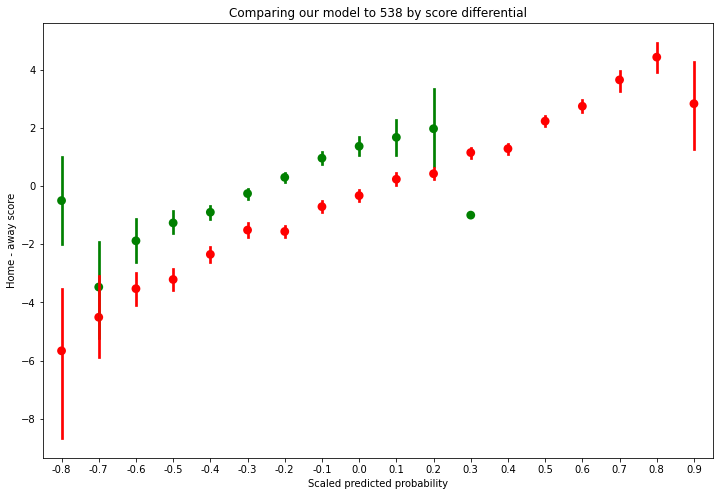

In [275]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.pointplot(x='home_win_prob_rounded_scaled', y='score_diff', data=fte_df, orient='v', join=False, label='538', color='green')
sns.pointplot(x='nn_proba_scaled_rounded', y='score_diff', data=df, orient='v', join=False, label='NN', color='red')
plt.xlabel('Scaled predicted probability')
plt.ylabel('Home - away score')
plt.title('Comparing our model to 538 by score differential');

The number of games in each dataset don't match (or are even close), even though the seasons match. Not sure what's going on there.

In [245]:
fte_df.shape[0]

9861

In [248]:
df.shape[0]

21238

In [265]:
fte_df['season'].min(), fte_df['season'].max()

(2016, 2019)

In [264]:
df['Y'].min(), df['Y'].max()

(2016, 2019)

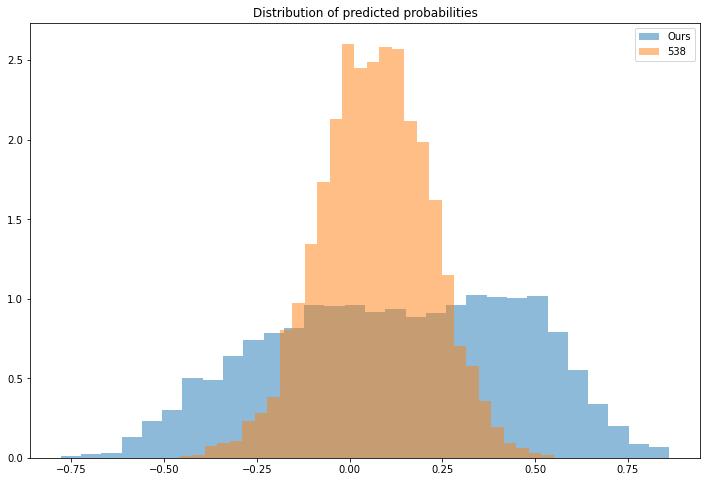

In [276]:
plt.figure(figsize=(12, 8))

plt.hist(df['nn_proba_scaled'], bins=30, label='Ours', density=True, alpha=0.5)
plt.hist(2 * (fte_df['elo_prob1'] - 0.5), bins=30, label='538', density=True, alpha=0.5)
plt.title('Distribution of predicted probabilities')
plt.legend();